In [92]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import math
import scipy.linalg as la
from scipy import optimize as opt
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

#Set up values 

import time

def rouwen(rho, mu, step, num):
    '''
    Adapted from Lu Zhang and Karen Kopecky. Python by Ben Tengelsen.
    Construct transition probability matrix for discretizing an AR(1)
    process. This procedure is from Rouwenhorst (1995), which works
    well for very persistent processes.

    INPUTS:
    rho  - persistence (close to one)
    mu   - mean and the middle point of the discrete state space
    step - step size of the even-spaced grid
    num  - number of grid points on the discretized process

    OUTPUT:
    dscSp  - discrete state space (num by 1 vector)
    transP - transition probability matrix over the grid
    '''

    # discrete state space
    dscSp = np.linspace(mu -(num-1)/2*step, mu +(num-1)/2*step, num).T

    # transition probability matrix
    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T


    while transP.shape[0] <= num - 1:

        # see Rouwenhorst 1995
        len_P = transP.shape[0]
        transP = p * np.vstack((np.hstack((transP, np.zeros((len_P, 1)))), np.zeros((1, len_P+1)))) \
                + (1 - p) * np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
                + (1 - q) * np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
                + q * np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.


    # ensure columns sum to 1
    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return transP.T, dscSp

rho = 0.9
mu = 0.
num = 25
sigma = 0.02
step = 5 * sigma /12
    
pi, zvec = rouwen(rho, mu, step, num)

alpha = 0.35
beta = 0.98
kbar = (alpha * beta) ** (1 / (1 - alpha))
kvec = np.full((25), kbar)
weights = np.linspace(0.5, 1.5, 25)
kvec = weights * kbar

print(kbar)

0.1927826194504225


Problem 1
==========

In [93]:
#Use Uhlig's notation to find values of F, G, H, L, M

F = (alpha * kbar ** (alpha - 1)) / ((kbar ** alpha) - kbar)
G = - (((alpha + kbar ** (alpha - 1)) * alpha * kbar ** (alpha - 1) ) / (kbar ** alpha - kbar))
H = (alpha ** 2 * kbar ** 2 * (alpha - 1)) / (kbar ** alpha - kbar)
L = - (alpha * kbar ** ( 2 * alpha - 1))/(kbar ** alpha - kbar)
M = (alpha **2 * kbar ** (2 * (alpha - 1))) / (kbar ** alpha - kbar)

P1 = (-G + math.sqrt(G **2 - 4 * F * H)) / (2 * F)
P2 = (-G - math.sqrt(G **2 - 4 * F * H)) / (2 * F)

if la.norm(P1) < 1:
    P = P1
else:
    P = P2

N = rho

Q = - (L * N + M) / (F * N + F * P + G)

In [94]:
def Modeldyn1(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (Kpp, Kp, K, Zp, Z) = theta0
    
    # Evaluate Euler equations
    E = beta * ((alpha * np.exp(Zp) * Kp **(alpha - 1))/( np.exp(Zp) * Kp ** alpha - Kpp)) - \
    1 / (np.exp(Z) * K **alpha - Kp)
    
    return E

In [95]:
alpha = 0.35
beta = 0.98
kbar = (alpha * beta) ** (1 / (1 - alpha))

params = (alpha, beta)

# set LinApp parameters
Zbar = np.array([0.])
nx = 1
ny = 0
nz = 1
logX = False
Sylv = 0

# take a guess for steady state values of k 
guessXY = 0.1

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn1, params, guessXY, Zbar, nx, ny)
kbar = XYbar[0]
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, 0., 0.])

# check SS solution
check = Modeldyn1(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn1, params, theta0, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)

XYbar:  [ 0.19278262]
check:  4.4408920985e-16
FF:  [[ 7.33367648]]
GG:  [[-23.9477678]]
HH:  [[ 7.48334336]]
LL:  [[-1.41380536]]
MM:  [[ 4.12188152]]
PP: [[ 0.35]]
QQ [[ 0.19278262]]
RR: []
SS []


In [96]:
optK_linear = np.zeros((25,25))
optK_cfs = np.zeros((25,25))

for i in range (0, len(kvec)):
    for j in range (0, len(zvec)):
        optK_linear[j,i] = kbar + PP * (kvec[i] - kbar) + QQ * zvec[j]
        optK_cfs[j,i] = alpha * beta * np.exp(zvec[j]) * kvec[i] ** alpha
        

In [97]:
optK_vfi = np.loadtxt('optK_vfi', delimiter=',')

<IPython.core.display.Javascript object>


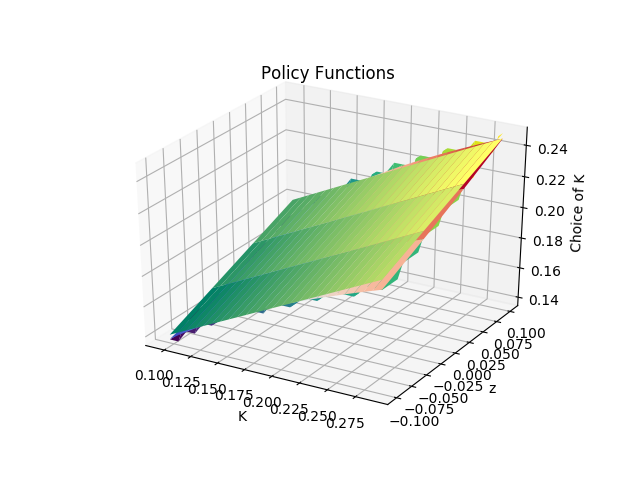

In [98]:
#Plot

import matplotlib

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

kvec_mesh, zvec_mesh = np.meshgrid(kvec, zvec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(kvec_mesh, zvec_mesh, optK_linear, rstride=8,
                cstride=1, cmap=cmap1, label =  'Linearization')
ax.plot_surface(kvec_mesh, zvec_mesh, optK_cfs, rstride=8,
                cstride=1, cmap=cm.coolwarm, label = 'Closed Form Solution')
ax.plot_surface(kvec_mesh, zvec_mesh, optK_vfi, rstride=8,
                cstride=1, cmap='viridis', label = 'Value Function Iteration')
ax.set_title('Policy Functions')
ax.set_xlabel(r'K')
ax.set_ylabel(r'z')
ax.set_zlabel(r'Choice of K')
#ax.legend()

The blue-red graph is from our linearization method. The wavy one is from our VFI method and the last graph (different gradients of green) is from our closed form solution.

Problem 2
==========

In [99]:
# set LinApp parameters
Zbar = np.array([0.])
nx = 1
ny = 0
nz = 1
logX = True
Sylv = 0

alpha = 0.35
beta = 0.98
kbar = (alpha * beta) ** (1 / (1 - alpha))
params = (alpha, beta)

# take a guess for steady state values of k 
guessXY = 0.1

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn1, params, guessXY, Zbar, nx, ny)
kbar = XYbar[0]
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, 0., 0.])

# check SS solution
check = Modeldyn1(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn1, params, theta0, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)

XYbar:  [ 0.19278262]
check:  4.4408920985e-16
FF:  [[ 1.41380536]]
GG:  [[-4.61671341]]
HH:  [[ 1.44265853]]
LL:  [[-1.41380536]]
MM:  [[ 4.12188152]]
PP: [[ 0.35]]
QQ [[ 1.]]
RR: []
SS []


In [100]:
optK_linear = np.zeros((25,25))
optK_cfs = np.zeros((25,25))

for i in range (0, len(kvec)):
    for j in range (0, len(zvec)):
        optK_linear[j,i] = PP * ((kvec[i] - kbar) / kbar) + QQ * (zvec[j] - 0)
        optK_cfs[j,i] = alpha * beta * np.exp(zvec[j]) * kvec[i] ** alpha

#Convert it back:
optK_linear = kbar * np.exp(optK_linear)

<IPython.core.display.Javascript object>


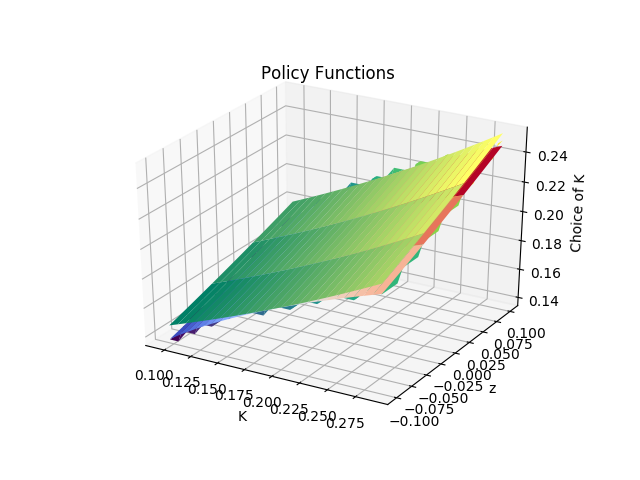

In [101]:
#Plot 2

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

kvec_mesh, zvec_mesh = np.meshgrid(kvec, zvec)

fig2 = plt.figure()
ax = fig2.gca(projection='3d')
ax.plot_surface(kvec_mesh, zvec_mesh, optK_linear, rstride=8,
                cstride=1, cmap=cmap1, label =  'Linearization')
ax.plot_surface(kvec_mesh, zvec_mesh, optK_cfs, rstride=8,
                cstride=1, cmap=cm.coolwarm, label = 'Closed Form Solution')
ax.plot_surface(kvec_mesh, zvec_mesh, optK_vfi, rstride=8,
                cstride=1, cmap='viridis', label = 'Value Function Iteration')
ax.set_title('Policy Functions')
ax.set_xlabel(r'K')
ax.set_ylabel(r'z')
ax.set_zlabel(r'Choice of K')
#ax.legend()

The blue-red graph is from our linearization method. The wavy one is from our VFI method and the last graph (different gradients of green) is from our closed form solution.

Problem 3
==========

$$\begin{align*}
E_t \{ F ( P \tilde{X}_t + Q \tilde{Z}_{t+1} ) + G ( P \tilde{X}_{t-1} + Q \tilde{Z}_t ) + H \tilde{X}_{t-1} + L(N \tilde{Z}_{t} + \epsilon_{t+1} + M \tilde{Z}_t\} &= 0\\
E_t \{ F ( P (P\tilde{X}_{t-1} + Q \tilde{Z}_t) + Q (N \tilde{Z}_{t}  + \epsilon_{t+1})) + GP \tilde{X}_{t-1} + GQ \tilde{Z}_t  + H \tilde{X}_{t-1} + LN \tilde{Z}_{t} + L\epsilon_{t+1} + M \tilde{Z}_t\} &= 0\\
E_t \{ FPP\tilde{X}_{t-1} + FPQ \tilde{Z}_t) + FQN \tilde{Z}_{t}  FQ\epsilon_{t+1})) + GP \tilde{X}_{t-1} + GQ \tilde{Z}_t  + H \tilde{X}_{t-1} + LN \tilde{Z}_{t} + L\epsilon_{t+1} + M \tilde{Z}_t\} &= 0\\
E_t \{ [(FP+G)P + H ] \tilde{X}_{t-1} + [FPQ + FQN + GQ + LN + M ]\tilde{Z}_{t} + (FQ+L) \epsilon_{t+1}\} &= 0\\
E_t \{ [(FP+G)P + H ] \tilde{X}_{t-1} + [(FQ+L)N + (FP+G)Q +M ]\tilde{Z}_{t} + (FQ+L) \epsilon_{t+1}\} &= 0\\
[(FP+G)P + H ] \tilde{X}_{t-1} + [(FQ+L)N + (FP+G)Q +M ]\tilde{Z}_{t} + (FQ+L) E_t\{\epsilon_{t+1}\} &= 0\\
[(FP+G)P + H ] \tilde{X}_{t-1} + [(FQ+L)N + (FP+G)Q +M ]\tilde{Z}_{t} &= 0\\
\end{align*}
$$

Problem 4
==========

In [102]:
def Modeldefs4(Xp, X, Y, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Y: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        u: utiity
    '''
    
    # unpack input vectors
    kp = Xp
    k = X
    ell = Y
    z = Z
    
    # find definintion values
    y = k**alpha*(np.exp(Z)*ell)**(1-alpha)
    w = (1-alpha) * k ** (alpha) * ell ** (-alpha) * np.exp(Z) ** (1-alpha)
    r = alpha * (k ** (alpha-1)) * (ell ** (1-alpha)) * np.exp(Z) ** (1-alpha)
    T = tao * ((w * ell) + (r - delta) * k)
    c = (1 - tao) * (w*ell + (r - delta)*k) + k - kp + T
    u = (((c ** (1-gamma)) - 1) / (1-gamma)) + a * (((1 - ell) ** (1 - ci) - 1) / (1 - ci))
    return Y, w, r, c, u, T

In [103]:
def Modeldyn4(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    
    # find definitions for now and next period
    y, w, r, c, u, T = Modeldefs4(Xp, X, Y, Z, params)
    yp, wp, rp, cp, up, Tp = Modeldefs4(Xpp, Xp, Yp, Zp, params)
    
    # Evaluate Euler equations
    ell = Y
    E1 = (c ** (-gamma) * w * (1 - tao)) / (a * (1 - ell) ** (-ci)) - 1
    E2 = beta * (cp / c) ** (-gamma) * ((rp - delta) * (1 - tao) + 1) - 1
    
    return np.array([E1, E2])

In [104]:
gamma = 2.5
ci = 1.5
beta = 0.98
alpha = 0.4
delta = 0.1
z = 0
tao = 0.05
a = 0.5

# make parameter list to pass to functions
params = (alpha, beta, gamma, delta, a, tao, ci, rho)

# set LinApp parameters
Zbar = np.array([0.])
nx = 1
ny = 1
nz = 1
logX = False
Sylv = 0

In [105]:
# take a guess for steady state values of k and ell
guessXY = np.array([0.1, .25])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn4, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta04 = np.array([kbar, kbar, kbar, ellbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn4(theta04, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

XYbar:  [ 4.22522903  0.57979145]
check:  [ -9.32587341e-15   0.00000000e+00]


In [106]:
ybar, wbar, rbar, cbar, ubar, Tbar = Modeldefs4(kbar, kbar, ellbar, 0, params)
print ('Ybar: ', ybar)
print ('wbar: ', wbar)
print ('rbar: ', rbar)
print ('cbar: ', cbar)
print ('ubar: ', ubar)
ibar = delta * kbar
print('ibar: ', ibar)
lbar = XYbar[1]
kbar = XYbar[0]
Tbar = tao * ((wbar * lbar) + (rbar - delta) * kbar)
print('Tbar: ', Tbar)

ss_vals1 = np.array([cbar, wbar, lbar, rbar, kbar, Tbar, ibar, ybar])

Ybar:  0.579791453167
wbar:  1.32795276835
rbar:  0.121482277121
cbar:  0.860703206154
ubar:  -0.710872638118
ibar:  0.422522902678
Tbar:  0.0430351603077


In [107]:
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn4, params, theta04, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)

FF:  [[ 2.90460171]]
GG:  [[-5.88766154]]
HH:  [[ 2.96699916]]
LL:  [[-2.16849645]]
MM:  [[ 2.23635645]]
Sylvester equation solver condition is not satisfied; proceed with the original method...
PP: [[ 0.91529369]]
QQ [[ 0.54504226]]
RR: [[-0.02633647]]
SS [[-0.00655754]]


Problem 5
=============

In [108]:
def equations2(inputs, params):
    c, w, l, r, k, T = inputs
    gamma, ci, beta, alpha, a, delta, z, tao = params
    diff1 = c - (1 - tao) * (w * l + (r - delta) * k) - T
    diff2 = c ** (-gamma) - beta * c ** (-gamma) * ((r - delta) * (1- tao) + 1)
    diff3 = a * (1 - l) ** (-ci) - (c ** (-gamma) * w * (1- tao))
    diff4 = r - alpha * k ** (alpha - 1) * l ** (1 - alpha)
    diff5 = w - (1-alpha) * l ** (-alpha) * k ** (alpha)
    diff6 = tao * (w * l + (r-delta) * k) - T
    diff_vec = np.array([diff1, diff2, diff3, diff4, diff5, diff6])
    return la.norm(diff_vec)

c_init = 5
w_init = 5
l_init = 0.5
r_init = 0.5
k_init = 5
t_init = 0.5

init_vec = np.array([c_init, w_init, l_init, r_init, k_init, t_init])
params = [gamma, ci, beta, alpha, a, delta, z, tao]
bounds = ((1e-15, None), (1e-15, None), (1e-15, .99), (1e-15, None), (1e-15, None), (1e-15, None))
results = opt.minimize(equations2, init_vec, args = params, method = 'L-BFGS-B', bounds = bounds, 
                       tol = 1e-15)
c, w, l, r, k, T = results.x
y = k**alpha*(np.exp(z)*l)**(1-alpha)
inv = delta * k 
ss_vals = np.array([c, w, l, r, k, T, inv, y])

In [109]:
eps = 1e-5
params = [gamma, ci, beta, alpha, a, delta, z, tao]
small_diff = np.zeros(len(params))
derive_mat = np.empty((len(params), len(ss_vals1)))


for i in range (0, len(params)):
    small_diff[i] = small_diff[i] + eps
    params = [gamma, ci, beta, alpha, a, delta, z, tao] + small_diff
    init_vec = np.array([c_init, w_init, l_init, r_init, k_init, t_init])
    bounds = ((1e-10, None), (1e-10, None), (1e-10, .99), (1e-10, None), (1e-10, None), (1e-10, None))
    results = opt.minimize(equations2, init_vec, args = params, method = 'L-BFGS-B', bounds = bounds, 
                       tol = 1e-15)
    c1, w1, l1, r1, k1, T1 = results.x
    y1 = k1**alpha*(l1)**(1-alpha)
    inv1 = y1-c1
    new_vals = np.array([c1, w1, l1, r1, k1, T1, inv1, y1])
    
    derive_val = (new_vals - ss_vals) / eps
    derive_mat[i,:] = derive_val
    params = params - small_diff
    small_diff[i] = small_diff[i] - eps

print(derive_mat)

[[  3.02514641e-02   1.10884890e-02   2.13289220e-02   1.96521797e-04
    2.44133228e-01  -3.13669436e-03   1.49293944e-01   5.79816990e-02]
 [ -1.58338537e-01  -3.96428268e-03  -1.14796207e-01   3.10830934e-03
   -9.06812284e-01  -6.26864681e-03   1.72966536e-02  -2.62605593e-01]
 [  1.76956025e+00   8.04151219e+00   2.55833747e-01  -1.10202833e+00
    6.58136122e+01   1.01855378e-01   6.68660086e+00   8.33459740e+00]
 [  2.14181897e+00   4.61362889e+00  -7.68667862e-01  -2.25667410e-02
    2.77119806e+01   1.04334655e-01   3.25423233e-01   2.34567849e+00]
 [ -3.22445878e-01   1.11942329e-01  -2.74121393e-01   6.36758604e-05
   -1.12972762e+00  -1.53085780e-02  -5.72522521e-02  -5.01261839e-01]
 [ -3.49223340e+00  -7.23459456e+00   1.31540618e+00   9.96790772e-01
   -4.79553377e+01  -1.74920064e-01  -4.65439594e-01  -4.07923670e+00]
 [ -2.59267064e-03   5.10151197e-03   3.38012057e-03  -1.66233330e-03
    6.87815290e-02  -1.21829046e-03   1.37000776e-01   1.28443961e-02]
 [ -1.7765981

In the above matrix, we have it in the following format:


$ \quad \quad \quad dc \quad dw \quad dl \quad dr \quad dk \quad dT \quad di \quad dy \\
d\gamma\\
d\xi\\
d\beta\\
d\alpha\\
da\\
d\delta\\
d\overline{z}\\
d\tau\\
$

In [113]:
#Tried using linearization to derive dy/dx, but it didn't work well. Perhaps not enough decimals?

eps = 1e-5
params = [alpha, beta, gamma, delta, a, tao, ci, rho]
small_diff = np.zeros(len(params))
derive_mat = np.empty((len(params), len(ss_vals1)))


for i in range (0, len(params)):
    small_diff[i] = small_diff[i] + eps
    params1 = np.copy(params + small_diff)
    XY1 = LinApp_FindSS(Modeldyn4, params1, guessXY, Zbar, nx, ny)
    y1, w1, r1, c1, u1, T1 = Modeldefs4(kbar, kbar, ellbar, 0, params1)
    i1 = delta * kbar
    l1 = XY1[1]
    k1 = XY1[0]
    T1 = tao * ((w1 * l1) + (r1 - delta) * k1)
    new_vals = np.array([c1, w1, l1, r1, k1, T1, i1, y1])
    derive_val = (new_vals - ss_vals1).astype(float) / float(eps)
    derive_mat[i,:] = derive_val
    params1 = np.copy(params)
    small_diff[i] = small_diff[i] - eps

Problem 6
===========

In [114]:
def Modeldefs6(Xp, X, Y, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Y: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        u: utiity
    '''
    
    # unpack input vectors
    kp = Xp
    k = X
    ell = Y
    z = Z
    
    # find definintion values
    y = k**alpha*(np.exp(z)*ell)**(1-alpha)
    w = (1-alpha) * k ** (alpha) * ell ** (-alpha) * np.exp(z)**(1-alpha)
    r = alpha * (k ** (alpha-1)) * (ell ** (1-alpha)) * (np.exp(z) ** (1-alpha))
    T = tao * ((w * ell) + (r - delta) * k)
    c = (1 - tao) * (w*ell + (r - delta)*k) + k - kp + T
    u = (((c ** (1-gamma)) - 1) / (1-gamma)) + a * (((1 - ell) ** (1 - ci) - 1) / (1 - ci))
    inv = kp - (1-delta) * k
    
    return y, w, r, c, u, T, inv

In [115]:
def Modeldyn6(theta06, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (Xpp, Ypp, Xp, Yp, X, Y, Zp, Z) = theta06
    
    # find definitions for now and next period
    y, w, r, c, u, T, inv = Modeldefs6(Xp, X, Yp, Z, params)
    yp, wp, rp, cp, up, Tp, invp = Modeldefs6(Xpp, Xp, Ypp, Zp, params)
    
    # Evaluate Euler equations
    ell = Yp
    E1 = (c ** (-gamma) * w * (1 - tao)) / (a * (1 - ell) ** (-ci)) - 1
    E2 = beta * (cp / c) ** (-gamma) * ((rp - delta) * (1 - tao) + 1) - 1
    
    return np.array([E1, E2])

In [116]:
gamma = 2.5
ci = 1.5
beta = 0.98
alpha = 0.4
delta = 0.1
z = 0
tao = 0.05
a = 0.5

# make parameter list to pass to functions
params = (alpha, beta, gamma, delta, a, tao, ci, rho)

# set LinApp parameters
Zbar = np.array([0.])
nx = 2
ny = 0
nz = 1
logX = True
Sylv = 0

In [117]:
# take a guess for steady state values of k and ell
guessXY = np.array([5, 0.5])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn6, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta06 = np.array([kbar, ellbar, kbar, ellbar, kbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn6(theta06, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

XYbar:  [ 4.22522903  0.57979145]
check:  [  9.54791801e-15   1.55431223e-15]


In [118]:
ybar, wbar, rbar, cbar, ubar, Tbar, ibar = Modeldefs6(kbar, kbar, ellbar, 0, params)
print ('Ybar: ', ybar)
print ('wbar: ', wbar)
print ('rbar: ', rbar)
print ('cbar: ', cbar)
print ('ubar: ', ubar)
print('ibar: ', ibar)
lbar = XYbar[1]
kbar = XYbar[0]
Tbar = tao * ((wbar * lbar) + (rbar - delta) * kbar)
print('Tbar: ', Tbar)

ss_vals1 = np.array([cbar, wbar, lbar, rbar, kbar, Tbar, ibar, ybar])

Ybar:  1.28322610883
wbar:  1.32795276835
rbar:  0.121482277121
cbar:  0.860703206154
ubar:  -0.710872638118
ibar:  0.422522902678
Tbar:  0.0430351603077


In [119]:
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn6, params, theta06, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)

FF:  [[  0.           0.        ]
 [ 12.27260744  -2.16849645]]
GG:  [[ 12.27260744  -4.70601255]
 [-24.87671844   2.23635645]]
HH:  [[-12.13625099   0.        ]
 [ 12.53625099   0.        ]]
LL:  [[ 0.        ]
 [-2.16849645]]
MM:  [[-1.63635645]
 [ 2.23635645]]
Sylvester equation solver condition is not satisfied; proceed with the original method...
PP: [[ 0.91529369  0.        ]
 [-0.19192699  0.        ]]
QQ [[ 0.12899709]
 [-0.01131016]]
RR: []
SS []


Problem 7
============

In [120]:
iterations = 10000
ystore = np.zeros((249, 10000))
cstore = np.zeros((249,10000))
istore = np.zeros((249,10000))
lstore = np.zeros((249,10000))

for n in range (0, iterations):
    gamma = 2.5
    ci = 1.5
    beta = 0.98
    alpha = 0.4
    delta = 0.1
    z = 0
    tao = 0.05
    a = 0.5
    # make parameter list to pass to functions
    params = (alpha, beta, gamma, delta, a, tao, ci, rho)

    eps = np.random.normal(0, 0.02, 250)
    ZZ = np.zeros((250))
    for i in range (1, 250):
        ZZ[i] = rho * ZZ[i-1] + eps[i]

    log_kbar = np.log(XYbar[0])
    log_lbar = np.log(XYbar[1])

    #K = np.full((250,1),log_kbar)
    #L = np.full((250,1),log_lbar)
    #KL = np.hstack((K, L)).reshape(2,250)
    KL = np.zeros((2,250))
    #KL[0,0] = log_kbar
    #KL[1,0] = log_lbar

    for j in range (0, 250):

        KL[:,j] = PP @ KL[:,j-1] + (QQ * ZZ[j]).reshape(2,)

    KL[0,:] = kbar * np.exp(KL[0,:])
    KL[1,:] = ellbar * np.exp(KL[1,:])

    KL0 = KL[:,:-1]
    KL1 = KL[:,1:]

    ys, ws, rs, cs, us, Ts, invs = Modeldefs6(KL0[0, :], KL1[0, :], KL0[1, :], 0, params)
    ls = KL0[1, :]
    
    ystore[:,n] = ys
    cstore[:,n] = cs
    istore[:,n] = invs
    lstore[:,n] = ls
    
print("done")

done


<IPython.core.display.Javascript object>


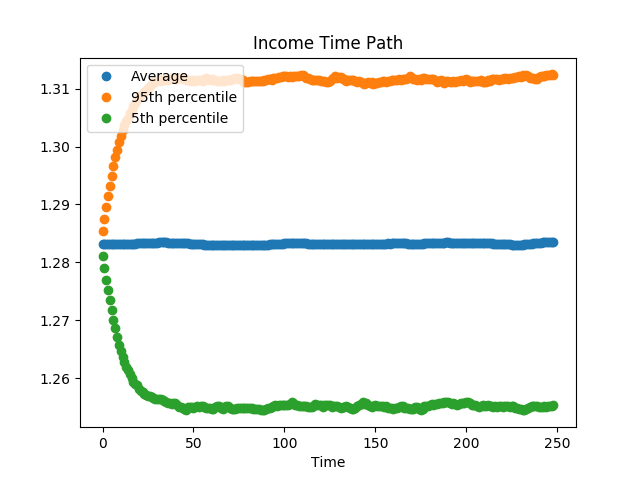

In [121]:
ymean = np.mean(ystore, axis = 1)
y95 = np.percentile(ystore, 95, axis = 1)
y5 = np.percentile(ystore, 5, axis = 1)

cmean = np.mean(cstore, axis = 1)
c95 = np.percentile(cstore, 95, axis = 1)
c5 = np.percentile(cstore, 5, axis = 1)

imean = np.mean(istore, axis = 1)
i95 = np.percentile(istore, 95, axis = 1)
i5 = np.percentile(istore, 5, axis = 1)

lmean = np.mean(lstore, axis = 1)
l95 = np.percentile(lstore, 95, axis = 1)
l5 = np.percentile(lstore, 5, axis = 1)

time = np.arange(0,249,1)

fig = plt.figure()
plt.plot(time, ymean, 'o', label = 'Average')
plt.plot(time, y95, 'o', label = '95th percentile')
plt.plot(time, y5, 'o', label = '5th percentile')
plt.title('Income Time Path')
plt.xlabel('Time')
plt.legend()

<IPython.core.display.Javascript object>


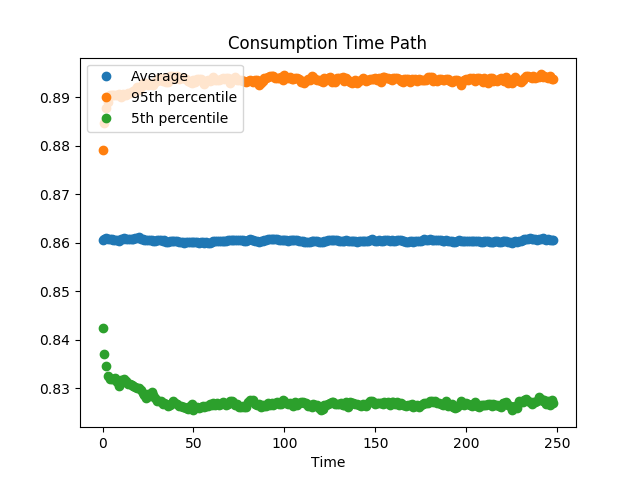

In [122]:
fig = plt.figure()
plt.plot(time, cmean, 'o', label = 'Average')
plt.plot(time, c95, 'o', label = '95th percentile')
plt.plot(time, c5, 'o', label = '5th percentile')
plt.title('Consumption Time Path')
plt.xlabel('Time')
plt.legend()

<IPython.core.display.Javascript object>


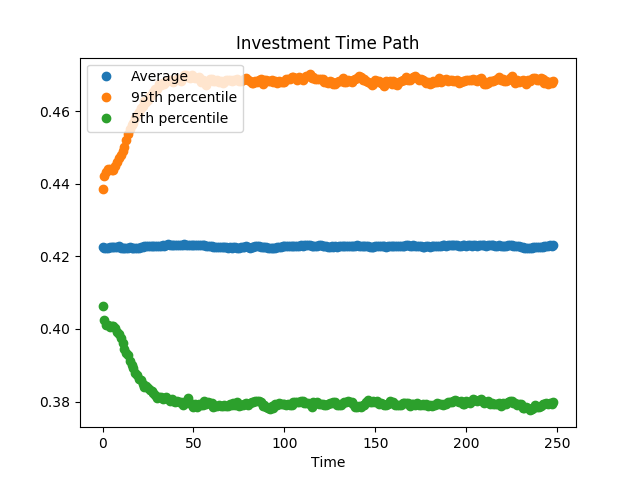

In [123]:
fig = plt.figure()
plt.plot(time, imean, 'o', label = 'Average')
plt.plot(time, i95, 'o', label = '95th percentile')
plt.plot(time, i5, 'o', label = '5th percentile')
plt.title('Investment Time Path')
plt.xlabel('Time')
plt.legend()

<IPython.core.display.Javascript object>


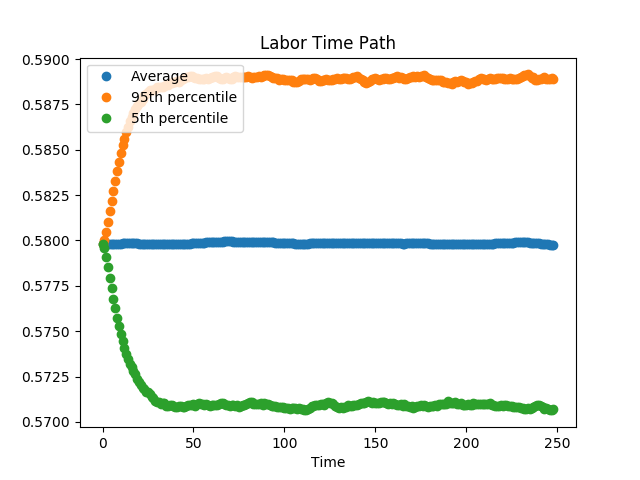

In [124]:
fig = plt.figure()
plt.plot(time, lmean, 'o', label = 'Average')
plt.plot(time, l95, 'o', label = '95th percentile')
plt.plot(time, l5, 'o', label = '5th percentile')
plt.title('Labor Time Path')
plt.xlabel('Time')
plt.legend()

Problem 8
============

In [125]:
iterations = 10000
ymean = np.zeros((10000))
ysd = np.zeros((10000))
ycov = np.zeros((10000))
yrv = np.zeros((10000))
ycyc = np.zeros((10000))
yper = np.zeros((10000))

cmean = np.zeros((10000))
csd = np.zeros((10000))
ccov = np.zeros((10000))
crv = np.zeros((10000))
ccyc = np.zeros((10000))
cper = np.zeros((10000))

imean = np.zeros((10000))
isd = np.zeros((10000))
icov = np.zeros((10000))
irv = np.zeros((10000))
icyc = np.zeros((10000))
iper = np.zeros((10000))

lmean = np.zeros((10000))
lsd = np.zeros((10000))
lcov = np.zeros((10000))
lrv = np.zeros((10000))
lcyc = np.zeros((10000))
lper = np.zeros((10000))

for n in range (0, iterations):
    gamma = 2.5
    ci = 1.5
    beta = 0.98
    alpha = 0.4
    delta = 0.1
    z = 0
    tao = 0.05
    a = 0.5
    # make parameter list to pass to functions
    params = (alpha, beta, gamma, delta, a, tao, ci, rho)

    eps = np.random.normal(0, 0.02, 250)
    ZZ = np.zeros((250))
    for i in range (1, 250):
        ZZ[i] = rho * ZZ[i-1] + eps[i]

    log_kbar = np.log(XYbar[0])
    log_lbar = np.log(XYbar[1])

    #K = np.full((250,1),log_kbar)
    #L = np.full((250,1),log_lbar)
    #KL = np.hstack((K, L)).reshape(2,250)
    KL = np.zeros((2,250))
    #KL[0,0] = log_kbar
    #KL[1,0] = log_lbar

    for j in range (0, 250):

        KL[:,j] = PP @ KL[:,j-1] + (QQ * ZZ[j]).reshape(2,)

    KL[0,:] = kbar * np.exp(KL[0,:])
    KL[1,:] = ellbar * np.exp(KL[1,:])

    KL0 = KL[:,:-1]
    KL1 = KL[:,1:]

    ys, ws, rs, cs, us, Ts, invs = Modeldefs6(KL0[0, :], KL1[0, :], KL0[1, :], 0, params)
    ls = KL0[1, :]
    
    ymean[n] = np.mean(ys)
    ysd[n] = np.std(ys)
    ycov[n] = np.mean(ys) / np.std(ys)
    yrv[n] = np.std(ys) / np.std(ys)
    ycyc[n] = np.correlate(ys, ys)[0]
    
    yb = ys[:-1]
    ya = ys[:1]
    yper[n] = np.correlate(yb, ya)[0]
    
    cmean[n] = np.mean(cs)
    csd[n] = np.std(cs)
    ccov[n] = np.mean(cs) / np.std(cs)
    crv[n] = np.std(cs) / np.std(ys)
    ccyc[n] = np.correlate(cs, ys)[0]
    
    cb = cs[:-1]
    ca = cs[:1]
    cper[n] = np.correlate(cb, ca)[0]
    
    imean[n] = np.mean(invs)
    isd[n] = np.std(invs)
    icov[n] = np.mean(invs) / np.std(invs)
    irv[n] = np.std(invs) / np.std(ys)
    icyc[n] = np.correlate(invs, ys)[0]
    
    ib = invs[:-1]
    ia = invs[:1]
    iper[n] = np.correlate(ib, ia)[0]
    
    lmean[n] = np.mean(ls)
    lsd[n] = np.std(ls)
    lcov[n] = np.mean(ls) / np.std(ls)
    lrv[n] = np.std(ls) / np.std(ys)
    lcyc[n] = np.correlate(ls, ys)[0]
    
    lb = ls[:-1]
    la = ls[:1]
    lper[n] = np.correlate(lb, la)[0]
    
print("done")

done


In [126]:
print('Average output mean: ', np.mean(ymean))
print('S.D. of output mean: ', np.std(ymean))
print('Average output volatility: ', np.mean(ysd))
print('S.D. of output volatility: ', np.std(ysd))
print('Average output coefficient of variation: ', np.mean(ycov))
print('S.D. of output coefficient of variation: ', np.std(ycov))
print('Average output relative volatility: ', np.mean(yrv))
print('S.D. of output relative volatility: ', np.std(yrv))
print('Average output persistence: ', np.mean(yper))
print('S.D. of output persistence: ', np.std(yper))
print('Average output cyclicality: ', np.mean(ycyc))
print('S.D. of output cyclicality: ', np.std(ycyc))

print('Average consumption mean: ', np.mean(cmean))
print('S.D. of consumption mean: ', np.std(cmean))
print('Average consumption volatility: ', np.mean(csd))
print('S.D. of consumption volatility: ', np.std(csd))
print('Average consumption coefficient of variation: ', np.mean(ccov))
print('S.D. of consumption coefficient of variation: ', np.std(ccov))
print('Average consumption relative volatility: ', np.mean(crv))
print('S.D. of consumption relative volatility: ', np.std(crv))
print('Average consumption persistence: ', np.mean(cper))
print('S.D. of consumption persistence: ', np.std(cper))
print('Average consumption cyclicality: ', np.mean(ccyc))
print('S.D. of consumption cyclicality: ', np.std(ccyc))

print('Average investment mean: ', np.mean(imean))
print('S.D. of investment mean: ', np.std(imean))
print('Average investment volatility: ', np.mean(isd))
print('S.D. of investment volatility: ', np.std(isd))
print('Average investment coefficient of variation: ', np.mean(icov))
print('S.D. of investment coefficient of variation: ', np.std(icov))
print('Average investment relative volatility: ', np.mean(irv))
print('S.D. of investment relative volatility: ', np.std(irv))
print('Average investment persistence: ', np.mean(iper))
print('S.D. of investment persistence: ', np.std(iper))
print('Average investment cyclicality: ', np.mean(icyc))
print('S.D. of investment cyclicality: ', np.std(icyc))

print('Average labor mean: ', np.mean(lmean))
print('S.D. of labor mean: ', np.std(lmean))
print('Average labor volatility: ', np.mean(lsd))
print('S.D. of labor volatility: ', np.std(lsd))
print('Average labor coefficient of variation: ', np.mean(lcov))
print('S.D. of labor coefficient of variation: ', np.std(lcov))
print('Average labor relative volatility: ', np.mean(lrv))
print('S.D. of labor relative volatility: ', np.std(lrv))
print('Average labor persistence: ', np.mean(lper))
print('S.D. of labor persistence: ', np.std(lper))
print('Average labor cyclicality: ', np.mean(lcyc))
print('S.D. of labor cyclicality: ', np.std(lcyc))

Average output mean:  1.28339440089
S.D. of output mean:  0.00650273645023
Average output volatility:  0.0149541665852
S.D. of output volatility:  0.00335269202026
Average output coefficient of variation:  90.289282489
S.D. of output coefficient of variation:  20.9212103534
Average output relative volatility:  1.0
S.D. of output relative volatility:  0.0
Average output persistence:  1.6467112111
S.D. of output persistence:  0.00340931282196
Average output cyclicality:  410.197207025
S.D. of output cyclicality:  4.15745768202
Average consumption mean:  0.860367651283
S.D. of consumption mean:  0.00126251005924
Average consumption volatility:  0.020006964588
S.D. of consumption volatility:  0.00209485182864
Average consumption coefficient of variation:  43.4764156661
S.D. of consumption coefficient of variation:  4.56726161413
Average consumption relative volatility:  1.38837263186
S.D. of consumption relative volatility:  0.260743935988
Average consumption persistence:  0.7411746728
S.D

Problem 9
=============

In [146]:
sigma = 0.02
rho - 0.9

ZI = np.zeros((45))
for i in range (5, 45):
    ZI[i] = sigma * rho **(i-5) 
    
log_kbar = np.log(XYbar[0])
log_lbar = np.log(XYbar[1])

KL = np.zeros((2,45))

for j in range (1, 45):
    KL[:,j] = PP @ KL[:,j-1] + (QQ * ZI[j]).reshape(2,)
    
KL[0,:] = kbar * np.exp(KL[0,:])
KL[1,:] = ellbar * np.exp(KL[1,:])

KL0 = KL[:,:-1]
KL1 = KL[:,1:]

ys, ws, rs, cs, us, Ts, invs = Modeldefs6(KL0[0, :], KL1[0, :], KL1[1, :], 0, params)
ls = KL0[1, :]

<IPython.core.display.Javascript object>


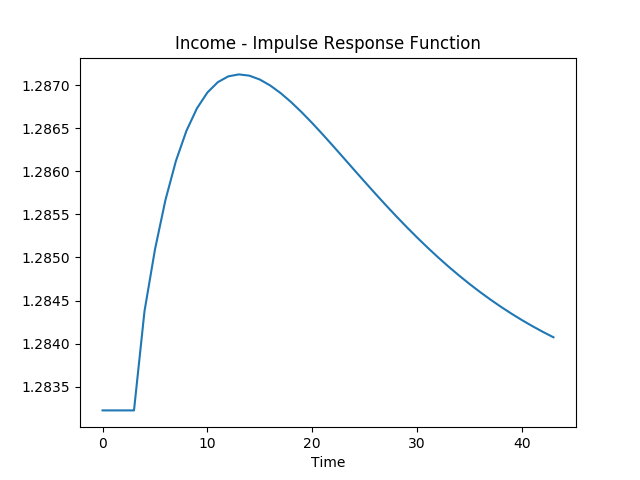

In [140]:
time = np.arange(0,44,1)

fig = plt.figure()
plt.plot(time, ys)
plt.title('Income - Impulse Response Function')
plt.xlabel('Time')

<IPython.core.display.Javascript object>


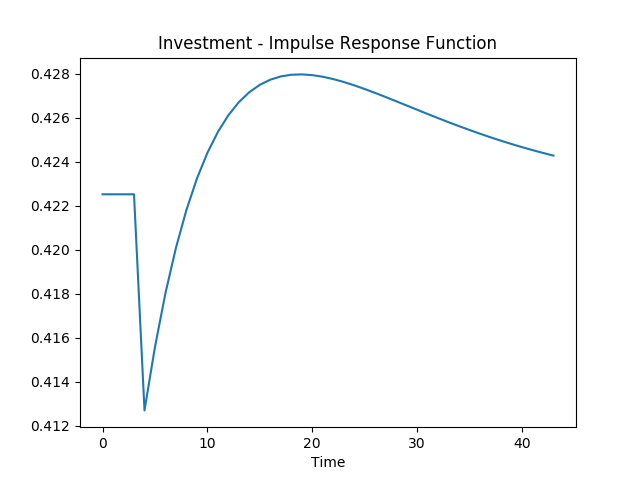

In [141]:
time = np.arange(0,44,1)

fig = plt.figure()
plt.plot(time, invs )
plt.title('Investment - Impulse Response Function')
plt.xlabel('Time')

<IPython.core.display.Javascript object>


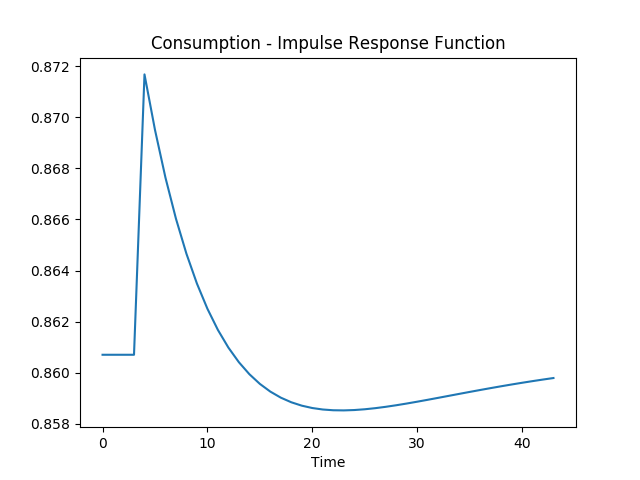

In [135]:
time = np.arange(0,44,1)

fig = plt.figure()
plt.plot(time, cs)
plt.title('Consumption - Impulse Response Function')
plt.xlabel('Time')

<IPython.core.display.Javascript object>


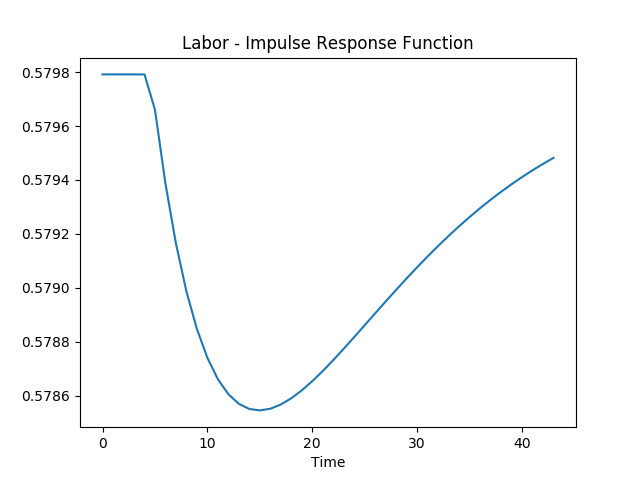

In [136]:
time = np.arange(0,44,1)
fig = plt.figure()
plt.plot(time, ls)
plt.title('Labor - Impulse Response Function')
plt.xlabel('Time')